In [4]:
import sympy as sp
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

In [5]:
def plot_matrix_heatmap(K_num, zero_color='lightgray', cmap='viridis', dpi=150, atol=1e-12):

    # Make a copy, mask zeros
    data = np.array(K_num, dtype=float)  # ensure float for NaN support
    mask = np.isclose(data, 0.0, atol=atol)
    data_masked = np.ma.array(data, mask=mask)  # mask zeros

    # Create a colormap and set color for masked (i.e. zero) entries
    cmap_mod = plt.get_cmap(cmap).copy()
    cmap_mod.set_bad(zero_color)  # color for masked entries

    fig, ax = plt.subplots(dpi=dpi)
    im = ax.imshow(data_masked, cmap=cmap_mod, interpolation='none', origin='upper')
    plt.colorbar(im, label='Stiffness Value')
    plt.title(f'Element Stiffness Matrix Heatmap ({data.shape[0]}×{data.shape[1]})')
    plt.xlabel('DOF Index')
    plt.ylabel('DOF Index')

    # Draw gridlines between cells
    n, m = data.shape
    ax.set_xticks(np.arange(-0.5, m, 1), minor=False)
    ax.set_yticks(np.arange(-0.5, n, 1), minor=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color='k', linestyle='-', linewidth=1)

    plt.show()


In [6]:
# Problem parameters

# Cuboid dimensions [mm]
L, W, H = sp.Integer(100.0), sp.Integer(50.0), sp.Integer(5.0) 

# Material properties
E_val = 7e4 # MPa
ν_val = 0.3 

# Traction load magnitude [N/mm²]
traction = 40 

In [7]:
ξ, η, ζ = sp.symbols('ξ η ζ')
E, ν = sp.symbols('E ν')

In [8]:
# all combinations of ±1 for (ξ_a, η_a, ζ_a)
nodes_natural_coordinates = [
    [-1, -1, -1],
    [ 1, -1, -1],
    [ 1,  1, -1],
    [-1,  1, -1],
    [-1, -1,  1],
    [ 1, -1,  1],
    [ 1,  1,  1],
    [-1,  1,  1],
]
N = [(1 + ξ*ξa)*(1 + η*ηa)*(1 + ζ*ζa)/sp.Integer(8) for (ξa, ηa, ζa) in nodes_natural_coordinates]
N

[(1 - ζ)*(1 - η)*(1 - ξ)/8,
 (1 - ζ)*(1 - η)*(ξ + 1)/8,
 (1 - ζ)*(η + 1)*(ξ + 1)/8,
 (1 - ζ)*(1 - ξ)*(η + 1)/8,
 (1 - η)*(1 - ξ)*(ζ + 1)/8,
 (1 - η)*(ζ + 1)*(ξ + 1)/8,
 (ζ + 1)*(η + 1)*(ξ + 1)/8,
 (1 - ξ)*(ζ + 1)*(η + 1)/8]

In [9]:
# Map from natural to physical coordinates
x, y, z = L/2 * (ξ + 1), W/2 * (η + 1), H/2 * (ζ + 1)

Dropped Escape call with ulEscapeCode : 0x03007703
Dropped Escape call with ulEscapeCode : 0x03007703
/home/takeshi/sandbox/learnFEM/.venv/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(
Dropped Escape call with ulEscapeCode : 0x03007703


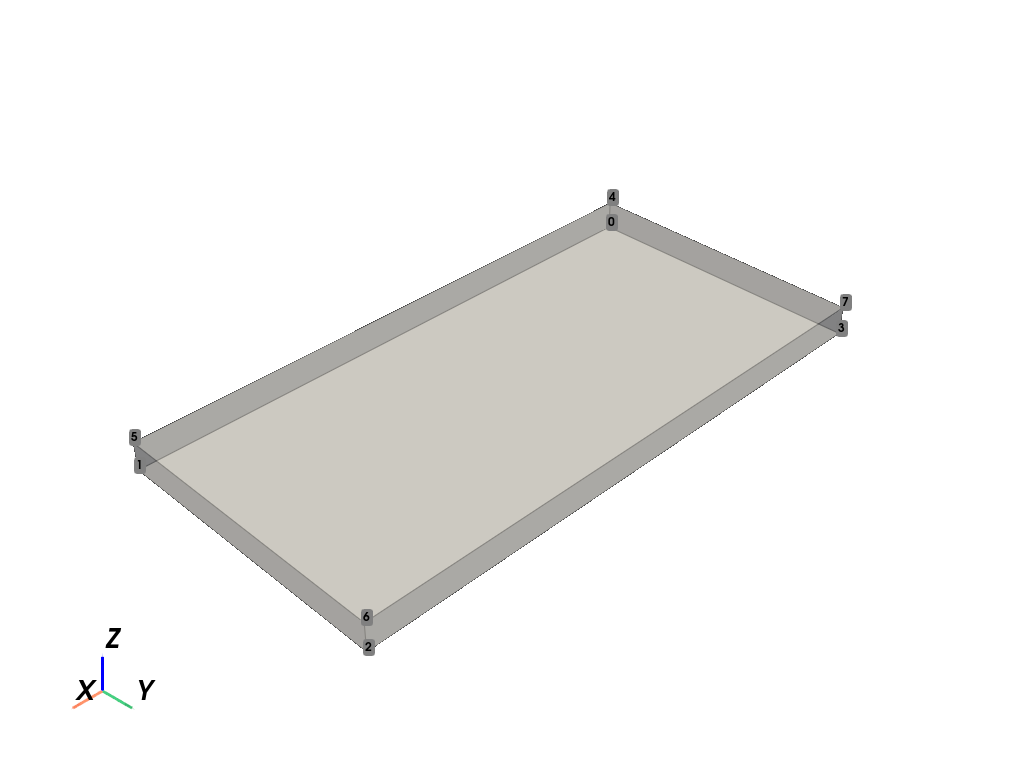

In [10]:
# Create a pv.UnstructuredGrid from nodes_natural_coordinates and the functions x, y, z
# Use a single hex element connectivity
nodes = np.array([[x.subs({ξ: ξa, η: ηa, ζ: ζa}).evalf(),
                   y.subs({ξ: ξa, η: ηa, ζ: ζa}).evalf(),
                   z.subs({ξ: ξa, η: ηa, ζ: ζa}).evalf()] for (ξa, ηa, ζa) in nodes_natural_coordinates], dtype=np.float64)

cells = np.hstack([[8], np.arange(8)])  # 8 nodes per hexahedron
cell_types = np.array([pv.CellType.HEXAHEDRON])
mesh = pv.UnstructuredGrid(cells, cell_types, nodes) 

# Point labels
points = mesh.points  # shape (n_nodes, 3)
labels = [str(i) for i in range(points.shape[0])]

pl = pv.Plotter()
pl.add_mesh(mesh, show_edges=True, color='lightgray', opacity=0.5)
pl.add_point_labels(points, labels,
                    point_size=5,       # size of the point glyph
                    font_size=12,       # font size of the labels
                    text_color='black',
                    italic=False, bold=True,
                    always_visible=True)

pl.add_axes(line_width=3,  # thickness of arrow‐axes
            cone_radius=0.06,
            shaft_length=0.9,
            tip_length=0.3,
            label_size=(0.5, 0.2))  # adjust as you like

pl.show()

In [11]:
# find the Jacobian matrix d(x,y,z)/d(ξ,η,ζ)
J = sp.Matrix([[sp.diff(x, ξ), sp.diff(x, η), sp.diff(x, ζ)],
               [sp.diff(y, ξ), sp.diff(y, η), sp.diff(y, ζ)],
               [sp.diff(z, ξ), sp.diff(z, η), sp.diff(z, ζ)]])
J

Matrix([
[50,  0,   0],
[ 0, 25,   0],
[ 0,  0, 5/2]])

In [12]:
J_inv = J.inv()
J_inv

Matrix([
[1/50,    0,   0],
[   0, 1/25,   0],
[   0,    0, 2/5]])

In [13]:
# dN_i/ dx = (dN_i / dξ) * (dξ / dx), etc.
dN_dξ = [sp.diff(Na, ξ) for Na in N]
dN_dη = [sp.diff(Na, η) for Na in N]
dN_dζ = [sp.diff(Na, ζ) for Na in N]

# now apply the chain rule with J_inv
dN_dx = []
dN_dy = []
dN_dz = []
for i in range(len(N)):
    
    # vector of reference derivatives for shape i
    dN_ref = sp.Matrix([dN_dξ[i], dN_dη[i], dN_dζ[i]])
    
    # multiply by the inverse Jacobian
    dN_phys = J_inv * dN_ref
    
    # extract physical derivatives
    dN_dx.append(dN_phys[0])
    dN_dy.append(dN_phys[1])
    dN_dz.append(dN_phys[2])

dN_dx


[-(1 - ζ)*(1 - η)/400,
 (1 - ζ)*(1 - η)/400,
 (1 - ζ)*(η + 1)/400,
 -(1 - ζ)*(η + 1)/400,
 -(1 - η)*(ζ + 1)/400,
 (1 - η)*(ζ + 1)/400,
 (ζ + 1)*(η + 1)/400,
 -(ζ + 1)*(η + 1)/400]

In [14]:
# Build B matrix as function of (ξ,η,ζ)
def B_sym():
    B = sp.zeros(6, 3*8)
    for a in range(8):
        i = 3*a
        B[0, i+0] = dN_dx[a]
        B[1, i+1] = dN_dy[a]
        B[2, i+2] = dN_dz[a]
        B[3, i+0] = dN_dy[a]
        B[3, i+1] = dN_dx[a]
        B[4, i+1] = dN_dz[a]
        B[4, i+2] = dN_dy[a]
        B[5, i+0] = dN_dz[a]
        B[5, i+2] = dN_dx[a]
    return B

B_sym_expr = B_sym()
B_sym_expr

Matrix([
[-(1 - ζ)*(1 - η)/400,                    0,                    0,  (1 - ζ)*(1 - η)/400,                    0,                    0, (1 - ζ)*(η + 1)/400,                   0,                   0, -(1 - ζ)*(η + 1)/400,                    0,                    0, -(1 - η)*(ζ + 1)/400,                    0,                    0,  (1 - η)*(ζ + 1)/400,                    0,                    0, (ζ + 1)*(η + 1)/400,                   0,                   0, -(ζ + 1)*(η + 1)/400,                    0,                    0],
[                   0, -(1 - ζ)*(1 - ξ)/200,                    0,                    0, -(1 - ζ)*(ξ + 1)/200,                    0,                   0, (1 - ζ)*(ξ + 1)/200,                   0,                    0,  (1 - ζ)*(1 - ξ)/200,                    0,                    0, -(1 - ξ)*(ζ + 1)/200,                    0,                    0, -(ζ + 1)*(ξ + 1)/200,                    0,                   0, (ζ + 1)*(ξ + 1)/200,                   0,           

In [15]:
# 4) define elasticity matrix D (isotropic, e.g. E=1, nu=0.3 for simplicity)
lam = E*ν / ((1+ν)*(1-2*ν))
mu  = E / (2*(1+ν))
D = sp.zeros(6,6)
for i in range(3):
    D[i,i] = lam + 2*mu
    for j in range(3):
        if i!=j:
            D[i,j] = lam
for i in range(3,6):
    D[i,i] = mu

D

Matrix([
[E*ν/((1 - 2*ν)*(ν + 1)) + 2*E/(2*ν + 2),                 E*ν/((1 - 2*ν)*(ν + 1)),                 E*ν/((1 - 2*ν)*(ν + 1)),           0,           0,           0],
[                E*ν/((1 - 2*ν)*(ν + 1)), E*ν/((1 - 2*ν)*(ν + 1)) + 2*E/(2*ν + 2),                 E*ν/((1 - 2*ν)*(ν + 1)),           0,           0,           0],
[                E*ν/((1 - 2*ν)*(ν + 1)),                 E*ν/((1 - 2*ν)*(ν + 1)), E*ν/((1 - 2*ν)*(ν + 1)) + 2*E/(2*ν + 2),           0,           0,           0],
[                                      0,                                       0,                                       0, E/(2*ν + 2),           0,           0],
[                                      0,                                       0,                                       0,           0, E/(2*ν + 2),           0],
[                                      0,                                       0,                                       0,           0,           0, E/(2*ν + 2)]])

In [16]:
# 5) form integrand for stiffness: integrand = B^T D B * detJ --> I am adding detJ here for convenience
detJ = sp.det(J)
detJ

3125

In [17]:
# Build integrand
K_sym = (B_sym_expr.T * D * B_sym_expr) * detJ
K_sym.simplify()
K_sym # 24 x 24 symbolic stiffness matrix

Matrix([
[                                5*E*((ζ - 1)**2*(η - 1)**2*(ν - 1) + (ζ - 1)**2*(4*ν - 2)*(ξ - 1)**2 + (η - 1)**2*(400*ν - 200)*(ξ - 1)**2)/(256*(ν + 1)*(2*ν - 1)),                                                                                                             -5*E*(ζ - 1)**2*(η - 1)*(ξ - 1)/(256*(ν + 1)*(2*ν - 1)),                                                                                                            -25*E*(ζ - 1)*(η - 1)**2*(ξ - 1)/(128*(ν + 1)*(2*ν - 1)),                     5*E*((1 - ν)*(ζ - 1)**2*(η - 1)**2 - 2*(ζ - 1)**2*(2*ν - 1)*(ξ - 1)*(ξ + 1) - 200*(η - 1)**2*(2*ν - 1)*(ξ - 1)*(ξ + 1))/(256*(ν + 1)*(2*ν - 1)),                                                                                    5*E*(ζ - 1)**2*(η - 1)*(2*ν*(ξ + 1) - (2*ν - 1)*(ξ - 1))/(256*(ν + 1)*(2*ν - 1)),                                                                                   25*E*(ζ - 1)*(η - 1)**2*(2*ν*(ξ + 1) - (2*ν - 1)*(ξ - 1))/(128*(ν + 1)*(2*ν - 1)), 

In [18]:
# Replace E and nu with numeric values
K_sym = K_sym.subs({E: E_val, ν: ν_val})


# 6) lambdify K integrand for numeric evaluation
f_K = sp.lambdify((ξ,η,ζ), K_sym, 'numpy')

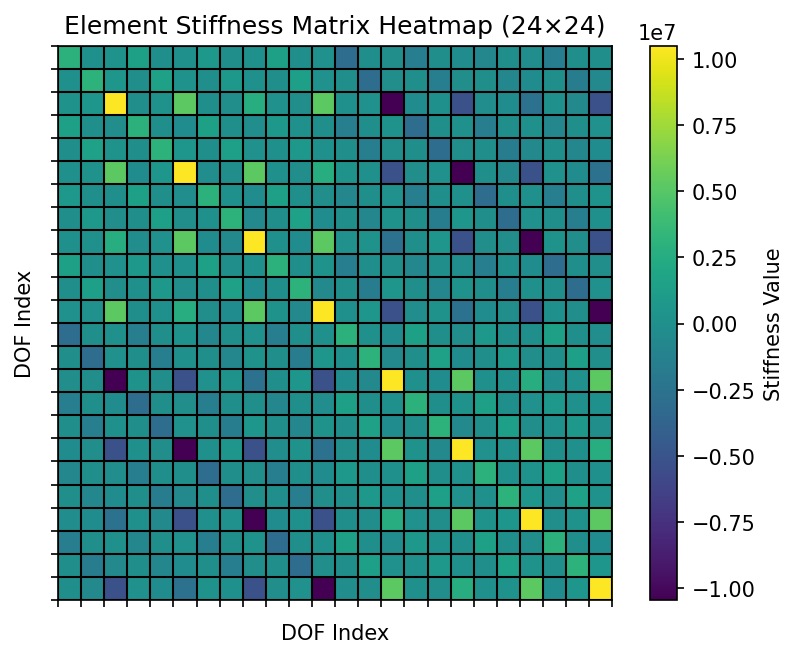

In [19]:
def integrate_K(n_gauss=2):
    # get Gauss points and weights for 1D
    if n_gauss == 1:
        points = [0.0]
        weights = [2.0]
    elif n_gauss == 2:
        p = 1/np.sqrt(3)
        points = [-p, p]
        weights = [1.0, 1.0]
    else:
        raise ValueError("extend as needed")
    K_e = np.zeros((24,24))
    for ξi, wξ in zip(points, weights):
        for ηj, wη in zip(points, weights):
            for ζk, wζ in zip(points, weights):
                K_e += f_K(ξi, ηj, ζk) * (wξ*wη*wζ)
    return K_e

# Example: compute for E=210e9, nu=0.3 with 2×2×2 Gauss
K_num = integrate_K(n_gauss=2)

plot_matrix_heatmap(K_num)


In [20]:
# LOAD VECTOR COMPUTATION

# Determinant of the surface Jacobian: can be obtained the cross product of the two tangent vectors on the surface
# on the surface ξ=1, parametrize with (η, ζ)
# surface Jacobian magnitude
x_surf = x.subs(ξ, 1)
y_surf = y.subs(ξ, 1)
z_surf = z.subs(ξ, 1)
dxdeta  = sp.Matrix([sp.diff(x_surf, η),
                     sp.diff(y_surf, η),
                     sp.diff(z_surf, η)])
dxdzeta = sp.Matrix([sp.diff(x_surf, ζ),
                     sp.diff(y_surf, ζ),
                     sp.diff(z_surf, ζ)])
J_surf = (dxdeta.cross(dxdzeta)).norm()
J_surf

125/2

In [22]:
# From N: list of 8 expressions corresponding to shape functions, compute the matrix [N] = [N1 0 0 N2 0 0 ... N8 0 0; 0 N1 0 0 N2 0 ... 0 N8; 0 0 N1 0 0 N2 ... 0 0 N8]
def N_matrix():
    N_mat = sp.zeros(3, 3*8)
    for a in range(8):
        i = 3*a
        N_mat[0, i+0] = N[a]
        N_mat[1, i+1] = N[a]
        N_mat[2, i+2] = N[a]
    return N_mat

N_mat_expr = N_matrix()


# For the boundary, I only care about the entries cooresponding to N1, N2, N5 and N6 (with Na ranging from 0 to 7)
boundary_dof_indices = [1, 2, 5, 6]

N_surf = N_mat_expr.subs({ξ: 1})
N_surf

Matrix([
[0, 0, 0, (1 - ζ)*(1 - η)/4,                 0,                 0, (1 - ζ)*(η + 1)/4,                 0,                 0, 0, 0, 0, 0, 0, 0, (1 - η)*(ζ + 1)/4,                 0,                 0, (ζ + 1)*(η + 1)/4,                 0,                 0, 0, 0, 0],
[0, 0, 0,                 0, (1 - ζ)*(1 - η)/4,                 0,                 0, (1 - ζ)*(η + 1)/4,                 0, 0, 0, 0, 0, 0, 0,                 0, (1 - η)*(ζ + 1)/4,                 0,                 0, (ζ + 1)*(η + 1)/4,                 0, 0, 0, 0],
[0, 0, 0,                 0,                 0, (1 - ζ)*(1 - η)/4,                 0,                 0, (1 - ζ)*(η + 1)/4, 0, 0, 0, 0, 0, 0,                 0,                 0, (1 - η)*(ζ + 1)/4,                 0,                 0, (ζ + 1)*(η + 1)/4, 0, 0, 0]])

In [ ]:
t = sp.Matrix([[0], [0], [-traction]])  # force load vector on the surface
surface_integrand = N_surf.transpose() * t * J_surf
traction_surf = sp.lambdify((η,ζ), surface_integrand, 'numpy')

def integrate_surface_load(n_gauss=2):
    if n_gauss == 2:
        p = 1/np.sqrt(3)
        pts = [-p, p]
        wts = [1.0, 1.0]
    else:
        raise ValueError("extend as needed")
    Fe = np.zeros((24,1))
    for ηi, wη in zip(pts, wts):
      for ζj, wζ in zip(pts, wts):
        Fe += traction_surf(ηi, ζj) * (wη*wζ)
    return Fe

loads_vec = integrate_surface_load(n_gauss=2)
loads_vec.T

array([[    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [-2500.],
       [    0.],
       [    0.],
       [-2500.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [-2500.],
       [    0.],
       [    0.],
       [-2500.],
       [    0.],
       [    0.],
       [    0.]])

In [27]:
loads_vec.T

array([[    0.,     0.,     0.,     0.,     0., -2500.,     0.,     0.,
        -2500.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., -2500.,     0.,     0., -2500.,     0.,     0.,     0.]])

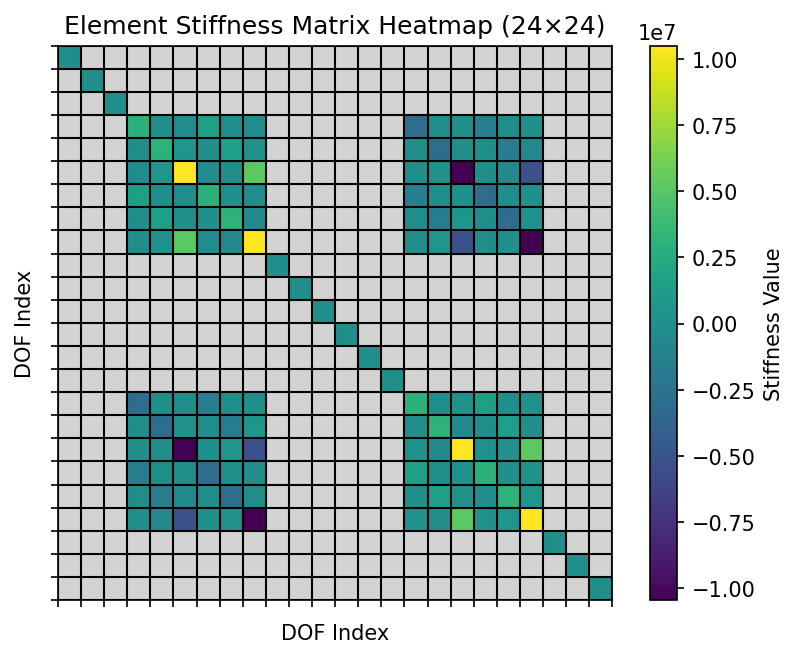

In [24]:
# DIRICHLET CONDITIONS
# Suppose node numbering 0–7 internally; boundary_nodes = [0, 3, 4, 7]  # (1,4,5,8 in 1-based)
boundary_nodes = [0, 3, 4, 7]  
# Convert to DOF indices
fixed_dofs = []
for n in boundary_nodes:
    fixed_dofs += [3*n + 0, 3*n + 1, 3*n + 2]  # x,y,z DOFs

for dof in fixed_dofs:
    # zero out row and column
    K_num[dof, :] = 0
    K_num[:, dof] = 0
    # set diagonal to 1
    K_num[dof, dof] = 1
    # zero force
    loads_vec[dof] = 0

plot_matrix_heatmap(K_num)

In [25]:
# Solve for displacements: K u = f
displacements = np.linalg.solve(K_num, loads_vec) 

# Add displacements to the pyvista grid for visualization
mesh.point_data['Displacements'] = displacements.reshape(-1, 3)
mesh.save('deformed_mesh.vtk')

In [26]:
np.linalg.norm(displacements.reshape(-1,3)).max()

np.float64(1.1817012081262026)